# Education and wage

An example of how **collider bias can reverse the sign of a relationship**, tainting our effect estimates.

In [ ]:
import warnings

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

np.random.seed(111)
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.plotting_context("notebook")

### Define the DAG and the simulation mechanism

The variables here are: education level, wage, and investment funds.

We assume the causal structure: education affects wage (E → W), and both education and wage affect investments (E → I ← W).

We are looking to understand **what effect education level has on wages**.

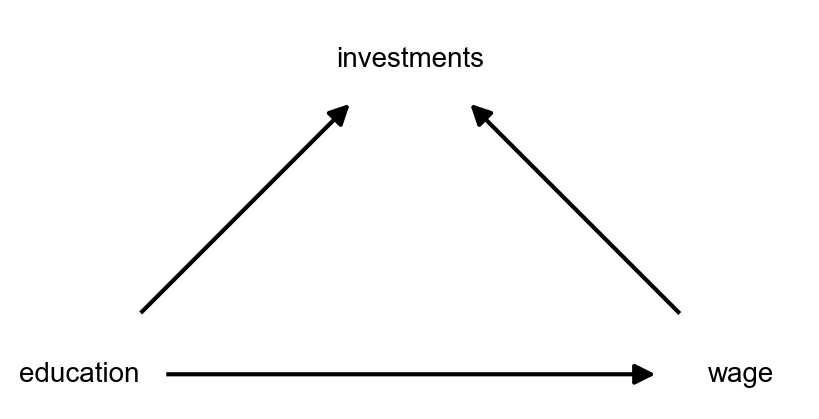

In [39]:
EDU = 'education'
WAGE = 'wage'
INV = '\ninvestments'
nodes = [EDU, WAGE, INV]
edges = [(EDU, WAGE), (EDU, INV), (WAGE, INV)]

G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Position nodes in a diamond layout
pos = {EDU: (0, 0), WAGE: (1, 0), INV: (0.5, 0.5),}
basic_settings = {
    "node_color": 'white',
    "node_size": 15000,
    "font_size": 20,
    "edgecolors": 'white',
    "linewidths": 2.5,
    "arrowsize": 30,
    "width": 3,
    "edge_color": 'k',
    "arrows": True,
}
plt.figure(figsize=(8, 4))
nx.draw(G, pos, with_labels=True, **basic_settings)

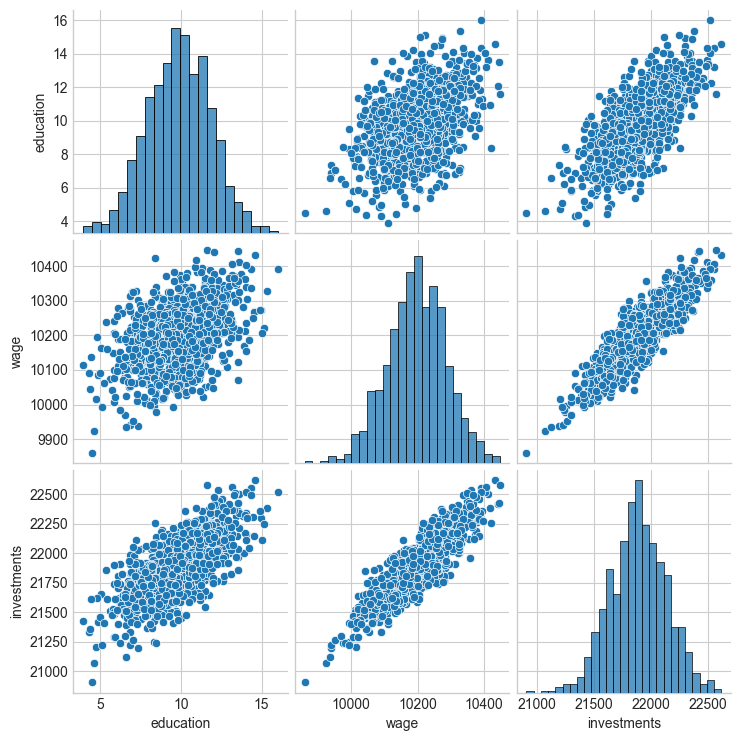

In [44]:
n_samples = 1000
TRUE_CAUSAL_EFFECT = 20.0

def wages_ground_truth(education):
    return 10000 + TRUE_CAUSAL_EFFECT * education + np.random.normal(0, 80, education.shape)

def investments_ground_truth(education, wage):
    return 1000 + 50 * education + 2 * wage + np.random.normal(0, 80, education.shape)

education = np.random.normal(loc=10, scale=2, size=n_samples)
wages = wages_ground_truth(education)
investments = investments_ground_truth(education, wages)

data = pd.DataFrame({
    'education': education,
    'wage': wages,
    'investments': investments
})

sns.pairplot(data)

### Bayesian linear regression

We'll fit two models:

- Wage ~ Education (does not condition on Investments)
- Wage ~ Education + Investments (conditions on the collider)

In [ ]:
# Standardize variables for MCMC
std_data = data.copy()
std_data['education_std'] = (data['education'] - data['education'].mean()) / data['education'].std()
std_data['wage_std'] = (data['wage'] - data['wage'].mean()) / data['wage'].std()
std_data['investments_std'] = (data['investments'] - data['investments'].mean()) / data['investments'].std()

n_samples = 5000
tune = 1000

# Wage ~ Education 
with pm.Model() as model_unbiased:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_edu = pm.Normal('beta_edu', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=5)
    mu = alpha + beta_edu * std_data['education_std']
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=std_data['wage_std'])
    trace_unbiased = pm.sample(n_samples, tune=tune, return_inferencedata=True)

# Wage ~ Education + Investments
with pm.Model() as model_collider:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_edu = pm.Normal('beta_edu', mu=0, sigma=10)
    beta_inv = pm.Normal('beta_inv', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=5)
    mu = alpha + beta_edu * std_data['education_std'] + beta_inv * std_data['investments_std']
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=std_data['wage_std'])
    trace_collider = pm.sample(n_samples, tune=tune, return_inferencedata=True)

### Comparing results

Let's compare the posterior distributions of the education effect from both models and see what we get.

Unbiased model effect estimate: 19.25 (95% CI: [16.73, 21.73])
Collider model effect estimate: -17.07 (95% CI: [-18.61, -15.53])
True causal effect: 20.00


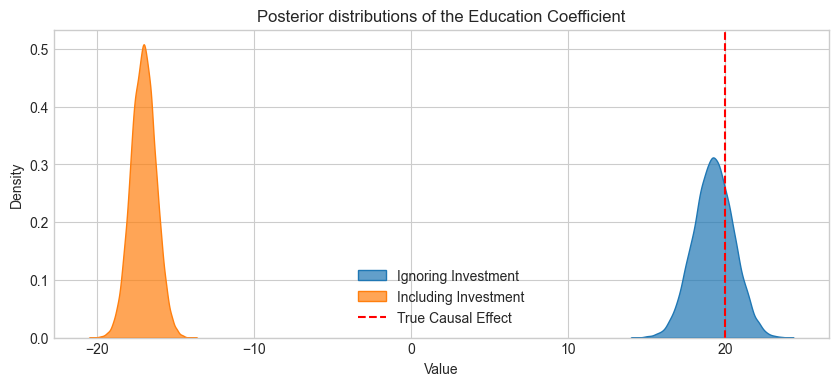

In [49]:
# Extract posterior samples
unbiased_effect = trace_unbiased.posterior['beta_edu'].values.flatten()
collider_effect = trace_collider.posterior['beta_edu'].values.flatten()

# Rescale to original units
std_wage = data['wage'].std()
std_edu = data['education'].std()
unbiased_effect_rescaled = unbiased_effect * std_wage / std_edu
collider_effect_rescaled = collider_effect * std_wage / std_edu


plt.figure(figsize=(10, 4))
sns.kdeplot(unbiased_effect_rescaled, fill=True, label='Ignoring Investment', alpha=0.7)
sns.kdeplot(collider_effect_rescaled, fill=True, label='Including Investment', alpha=0.7)
plt.axvline(x=TRUE_CAUSAL_EFFECT, color='red', linestyle='--', label='True Causal Effect')
plt.title('Posterior distributions of the Education Coefficient')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

print("Unbiased model effect estimate: {:.2f} (95% CI: [{:.2f}, {:.2f}])".format(
    unbiased_effect_rescaled.mean(),
    np.percentile(unbiased_effect_rescaled, 2.5),
    np.percentile(unbiased_effect_rescaled, 97.5)
))
print("Collider model effect estimate: {:.2f} (95% CI: [{:.2f}, {:.2f}])".format(
    collider_effect_rescaled.mean(),
    np.percentile(collider_effect_rescaled, 2.5),
    np.percentile(collider_effect_rescaled, 97.5)
))
print("True causal effect: {:.2f}".format(TRUE_CAUSAL_EFFECT))

### Conclusions

The blue model did not consider investment and yielded a good causal effect estimate. Its estimated posterior for the wage coefficient was not only positive, but also almost centered around the true value (20)!

When investment was included (orange), the posterior coefficient distribution became negative, which is terrible. 

These results were expected from the DAG, as conditioning on a colider opens a non-causal path between the treatment (education) and the output variable (wage). The right approach to measuring the causal effect between them must be **ignoring the collider variable**.